In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../bin/imports.ipynb")

/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)
/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## Run scripts on cluster

In [11]:
def create_cluster_script(thresholds, tissues):
    
    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/AUC.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        #out_file.write("#$ -t 1-6\n".format(len(thresholds)))
        out_file.write("#$ -t 1-{0}\n".format(len(thresholds)))
        out_file.write("#$ -l h_vmem=5G\n")
        out_file.write("#$ -tc 50\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set thresholds=({0})\n".format(" ".join(thresholds)))
        out_file.write("set tissues=({0})\n".format(" ".join(tissues)))
        out_file.write("\n")

        out_file.write("set threshold=$thresholds[$SGE_TASK_ID]\n")
        out_file.write("set tissue=$tissues[$SGE_TASK_ID]\n")
        out_file.write("\n")
        
        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("\n")
  
        out_file.write("Rscript --vanilla /cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/prediction.tissue.shuffled.R $threshold $tissue\n")
                       
        out_file.write("date\n")

In [12]:
tissue_df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/patient_tissues.csv', index_col=0)

In [13]:
# first MHC-I only (driver, passenger, germline); then both (driver, passenger, germline)
tissues = list(tissue_df.Tissue.unique())
thresholds = ['2']*len(tissues)

create_cluster_script(thresholds, tissues)

In [14]:
tissues_over_100 = list(tissue_df.Tissue.value_counts()[tissue_df.Tissue.value_counts() > 100].index)

### Visualize results

In [6]:
all_auc, tissues_used = [], []
for tissue in tissues_over_100:
    print tissue
    tissue_auc = []
    for model in ['MHC_I', 'MHC_II', 'Both']:
        try:
            df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/tissues/predictions.muts_in_{0}.{1}.2.data.txt'.format(tissue, model),
                       sep=' ')
            #print tissue, model, metrics.roc_auc_score(df.label, df.predicted_prob)
            tissue_auc.append(metrics.roc_auc_score(df.label, df.predicted_prob))
        except:
            None
    if len(tissue_auc) == 3:
        tissues_used.append(tissue)
        all_auc.append(tissue_auc)

BRCA
GBM
OV
LUAD
UCEC
KIRC
HNSC
LGG
THCA
LUSC
PRAD
SKCM
COAD
STAD
BLCA
LIHC
CESC
KIRP
SARC
PAAD
ESCA
PCPG
READ
TGCT
LAML
THYM
KICH


In [7]:
auc_df = pd.DataFrame(all_auc)
auc_df.columns = ['MHC_I', 'MHC_II', 'Both']
auc_df.index = tissues_used

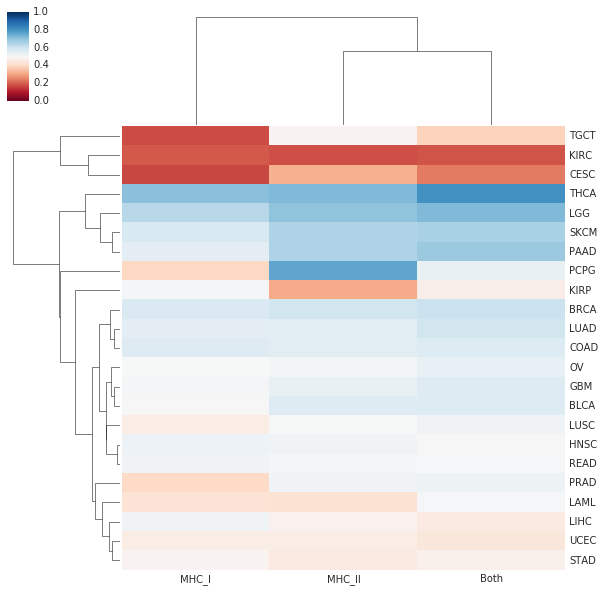

In [10]:
plt.figure(figsize=(4, 8))
sns.clustermap(all_auc, xticklabels=['MHC_I', 'MHC_II', 'Both'], yticklabels=tissues_used,
           cmap='RdBu', vmin=0, vmax=1)

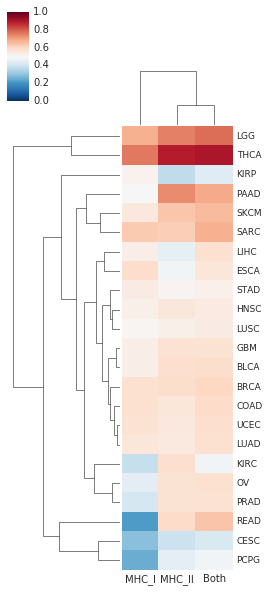

In [9]:
cm = sns.clustermap(all_auc, xticklabels=['MHC_I', 'MHC_II', 'Both'], yticklabels=tissues_over_100,
           cmap='RdBu_r', vmin=0, vmax=1)
hm = cm.ax_heatmap.get_position()
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=9)
cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.25, hm.height])
col = cm.ax_col_dendrogram.get_position()
cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.25, col.height*0.5])
plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/matched_models/tissue.AUC.pdf')

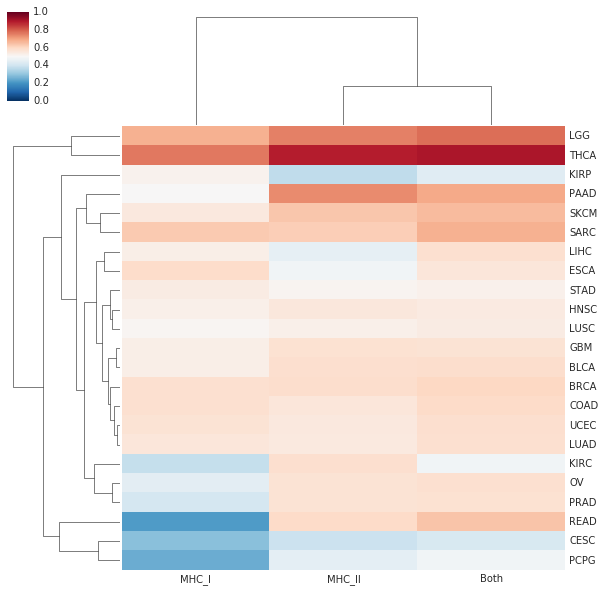

In [9]:
sns.clustermap(all_auc, xticklabels=['MHC_I', 'MHC_II', 'Both'], yticklabels=tissues_over_100,
           cmap='RdBu_r', vmin=0, vmax=1)
#hm = cm.ax_heatmap.get_position()
#plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), fontsize=9)
#cm.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.25, hm.height])
#col = cm.ax_col_dendrogram.get_position()
#cm.ax_col_dendrogram.set_position([col.x0, col.y0, col.width*0.25, col.height*0.5])

In [10]:
auc_df

,MHC_I,MHC_II,Both
BRCA,0.578588,0.589546,0.604510
GBM,0.532888,0.576712,0.572394
OV,0.446646,0.573817,0.581880
UCEC,0.571269,0.553549,0.583861
KIRC,0.379514,0.585908,0.481264
HNSC,0.530319,0.556031,0.546436
LUAD,0.560215,0.549665,0.579088
LGG,0.676484,0.750788,0.780661
THCA,0.764347,0.891010,0.909922
LUSC,0.508946,0.529635,0.541934


In [31]:
len(tissues_over_100), len(list(auc_df.MHC_II))

(23, 22)

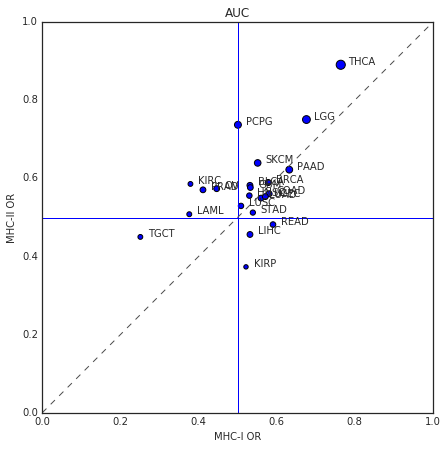

In [53]:
f, ax = plt.subplots(figsize=(7, 7))

plt.axhline(y=0.5)
plt.axvline(x=0.5)
plt.scatter(auc_df.MHC_I, auc_df.MHC_II, s=(auc_df.Both*10)**2)

plt.ylim(0, 1)
plt.xlim(0, 1)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")


for i, txt in enumerate(tissues_used):
    plt.annotate(txt, (list(auc_df.MHC_I)[i]+0.02, list(auc_df.MHC_II)[i]), size=10)

plt.xlabel('MHC-I OR')
plt.ylabel('MHC-II OR')
plt.title('AUC')

Pan-cancer results

In [78]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/Both.pan.thresh_2.cancer.txt',
           sep=' ')

,OR,CI_low,CI_high,predicted
1,1.426243,1.413139,1.439468,x
2,2.117561,2.104526,2.130677,z


Rank mutations based on their ability to predict? 